### Image recognition --- CIFAR-10

In [58]:
# download dataset
from torchvision import datasets

data_path = './data/' # the location which the data will be downloaded
cifar10_train = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [59]:
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')
img, label = cifar10_train[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FCBA0186ED0>, 1, 'car')

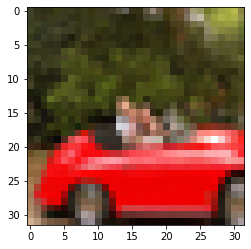

In [60]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

In [61]:
# transform img to tensor, label doesn't change
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape # 3 channels, 32 height, 32 width

torch.Size([3, 32, 32])

In [62]:
# transform imgs to tensor at the dataset step
cifar10_train = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.ToTensor()
)
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.ToTensor()
)

# check the type and dimension
img_t, _ = cifar10_train[99]
print(img_t.shape, img_t.dtype) # shape and dtype are not objects

torch.Size([3, 32, 32]) torch.float32


In [63]:
# what does transform do?
print(img_t.min(), img_t.max())
# turns data into 32-bit floating-point 
# scales the values down from 0.0 to 1.0
# changes from H W C to C H W

tensor(0.) tensor(1.)


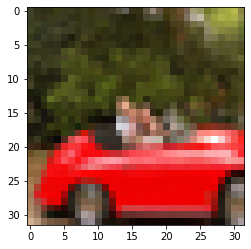

In [64]:
# whether it gets the same img
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [65]:
# normalization
import torch as t

# first calculate mean among all the images at each channel
# stack all the imgs to one tensor
# dim=3: stack along an extra dimension (CHW:0, 1, 2 dimension)
imgs = t.stack([img_t for img_t, _ in cifar10_train], dim=3)
imgs_v = t.stack([img_t for img_t, _ in cifar10_val], dim=3)
print(imgs.shape)

# compute the mean along each channel
# view keeps the 3 channel, and merges all the remaining dimensions into one
mean_imgs = imgs.view(3, -1).mean(dim=1)
std_imgs = imgs.view(3, -1).std(dim=1)

mean_imgs_v = imgs_v.view(3, -1).mean(dim=1)
std_imgs_v = imgs_v.view(3, -1).std(dim=1)

# concatenate it after transform
cifar10_train = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean_imgs, std_imgs)
    ])   
)

cifar10_test = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean_imgs_v, std_imgs_v)
    ])
)

torch.Size([3, 32, 32, 50000])


In [66]:
print(mean_imgs, std_imgs)

tensor([0.4914, 0.4822, 0.4465]) tensor([0.2470, 0.2435, 0.2616])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


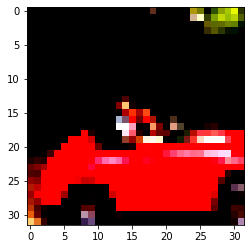

In [67]:
# plot normalized img
img_t, _ = cifar10_train[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

### Tell bird and plane apart

In [68]:
# subclass of datasets only containing bird and plane
# label: plane--0, bird--2
label_map = {0: 0, 2: 1}
label_name = ['plane', 'bird']

cifar10_birdplane_train = [(img, label_map[label])
                           for img, label in cifar10_train
                           if label in label_map]
cifar10_birdplane_test = [(img, label_map[label])
                          for img, label in cifar10_test
                          if label in label_map]

In [69]:
import torch.nn as nn

# softmax: change each value into classification probability
x = t.tensor([[1.0, 2.0, 3.0], [1.0, 2.0, 3.0]])
# dim =0 means count row(0) along each column
# dim=1 means count column(1) along each row
softmax = nn.Softmax(dim=1)
print(softmax(x))

_, pa = t.max(softmax(x), dim=1)
_

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])


tensor([0.6652, 0.6652])

In [70]:
from collections import OrderedDict

# strech each img into a tensor with 3*32*32=3072 features 
img1, label1 = cifar10_birdplane_train[1]
img_tensor = img1.view(-1).unsqueeze(0)

model = nn.Sequential(OrderedDict([
    ('hidden linear', nn.Linear(3072, 520)),
    ('hidden activate', nn.Tanh()),
    ('output linear', nn.Linear(520, 2)),
    ('softmax', nn.LogSoftmax(dim=1)) # log probability for NLL loss.
]))

loss = nn.NLLLoss()

output = model(img_tensor)

# t.tensor([label1]) = tensor([1]), it can be converted with 
# one-hot encoding to [0, 1]
loss(output, t.tensor([label1])) 

tensor(0.3917, grad_fn=<NllLossBackward>)

In [71]:
# work flow
from torch import optim

# load data into minibatches
train_loader = t.utils.data.DataLoader(cifar10_birdplane_train,
                                      batch_size=64,
                                      shuffle=True) # shuffle at the start of each epoch

n_epoches = 10
optimizer = optim.SGD(model.parameters(), lr=1e-2)

for epoch in range(1, n_epoches+1):
    for imgs, labels in train_loader:
        batch = imgs.shape[0] # sometimes the batch size would not be 64
        outputs = model(imgs.view(batch, -1))
        loss_value = loss(outputs, labels)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print('epoch %d, loss %f'%(epoch, float(loss_value)))
    
# validation
test_loader = t.utils.data.DataLoader(cifar10_birdplane_test,
                                     batch_size=64,
                                     shuffle=True)

total = 0
correct = 0

with t.no_grad():# don't compute gradient
    for imgs, labels in test_loader:
        batch = imgs.shape[0]
        outputs = model(imgs.view(batch, -1))
        _, predicted = t.max(outputs, dim=1) # predicted is the predicted label
        total += labels.shape[0]
        # tensor could do this. == will compare each value in the tensor.
        correct += int((predicted == labels).sum()) 
        
    print('accuracy %f' % (correct/total))

epoch 10, loss 0.383636
accuracy 0.815000


### Using convolution kernel

In [72]:
# create convolution kernel
# 3: input channel, 16: output channel
# kernel_size=3 == kernel_size = (3,3)
conv_2d = nn.Conv2d(3, 16, kernel_size=3, padding=1)
print(conv_2d, '\n', conv_2d.weight.shape, '\n', conv_2d.bias.shape)

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 
 torch.Size([16, 3, 3, 3]) 
 torch.Size([16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 32, 32]) torch.Size([1, 16, 32, 32])


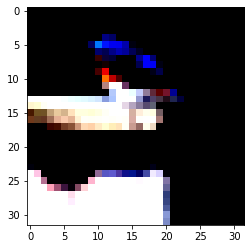

<function matplotlib.pyplot.show(*args, **kw)>

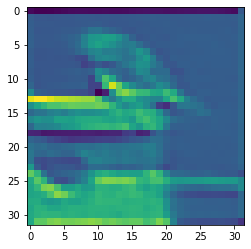

In [73]:
# using kernel on img
img, _ = cifar10_birdplane_train[1]

# add one dimension to indicate batch size=1 using unsqueeze(0)
con_img = conv_2d(img.unsqueeze(0))
print(img.unsqueeze(0).shape, con_img.shape)

# img[0] means to just get the first channel, and convert it into np.array
plt.imshow(img.permute(1, 2, 0))
plt.show()
# con_img[0,0] mneans to just get one batch and one channel
plt.imshow(con_img[0, 0].detach())
plt.show

In [74]:
# we could decide the value of weights and bias by ourself
with t.no_grad():
    conv_2d.bias.zero_()
# with t.no_grad():
    conv_2d.weight.fill_(1.0/9.0) # mean kernel

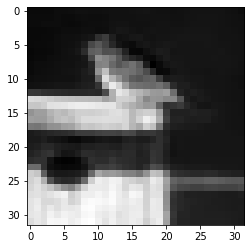

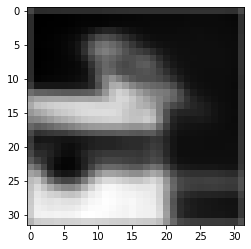

In [75]:
con_img = conv_2d(img.unsqueeze(0))

plt.imshow(img[0].detach(), cmap='gray')
plt.show()
# mean kernel generates a blurred img
plt.imshow(con_img[0,0].detach(), cmap='gray')
plt.show()

In [102]:
# personalized your submodule
import torch.nn.functional as F # functions without state

class Net(nn.Module):
    def __init__(self, n_chans1=16):
        super().__init__()
        self.n_chans1 = n_chans1
        # first convolution kernel
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        
        # pool layer. 2 means shrinking to the half of the input
        # 32*32 -> 16*16
        # self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        
        # 16*16 -> 8*8
        # self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2) # only two classes
        
    def forward(self, x):
        out = t.tanh(self.conv1(x))
        # pool 1
        out = F.max_pool2d(out, 2)
        out = t.tanh(self.conv2(out))
        # pool 2
        out = F.max_pool2d(out, 2)
        # stretch to 8*8*8 features
        out = out.view(-1, 8*8*self.n_chans1//2)
        out = t.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
        

In [103]:
# apply to one img
model = Net()

# it successfully generates two values (probabilities for two classes)
model(img.unsqueeze(0))

tensor([[-0.0628,  0.1771]], grad_fn=<AddmmBackward>)

In [108]:
import time

def train_loop(n_epoches, optimizer, model, loss_fn, train_loader):
    start_time = time.time()
    for epoch in range(1, n_epoches+1):
        loss_train = 0
        for imgs, labels in train_loader:
            output = model(imgs)
            loss = loss_fn(output, labels)
            
            # regularization using L2 norm lambda*sum(parameters^2)
            l2_lambda = 0.001
            l2_norm = sum([p.pow(2.0).sum() for p in model.parameters()])
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item() # transform the loss to a number to escape the gradients
        
        if epoch % 4 == 0:
            end_time = time.time()
            used_time = end_time-start_time
            print('epoch {}, training loss {}, time used {}'.format(
                epoch, loss_train/len(train_loader), used_time))

In [109]:
# train our model
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

train_loop(20, optimizer, model, loss_fn, train_loader)

epoch 4, training loss 0.4606045991372151, time used 16.86350679397583
epoch 8, training loss 0.3790031844263623, time used 31.33685278892517
epoch 12, training loss 0.35088771306405403, time used 45.512746810913086
epoch 16, training loss 0.33494753167507757, time used 58.03242492675781
epoch 20, training loss 0.32445409201133024, time used 70.461266040802


In [112]:
# measure accuracy using validation dataset
def validate(model, train_loader, test_loader):
    for name, data in [('train', train_loader), ('test', test_loader)]:
        correct = 0
        total = 0
        
        with t.no_grad():
            for imgs, labels in data:
                outputs = model(imgs)
                _, predicted = t.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum()) # similar to tensor.item()
        
        print('accuracy {} is {:.2f}'.format(name, correct/total))

In [113]:
validate(model, train_loader, test_loader)

accuracy train is 0.87
accuracy test is 0.86


In [110]:
# drop out to overcome overfitting
class Netdropout(nn.Module):
    def __init__(self, n_chans1=16):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        
        # add dropout to overcome overfitting: optional
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        
        # optional
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        
        # 16*16 -> 8*8
        # self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2) # only two classes
        
    def forward(self, x):
        out = F.max_pool2d(t.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(t.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8*8*self.n_chans1//2)
        out = t.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [111]:
train_loop(20, optimizer, Netdropout(), loss_fn, train_loader)

epoch 4, training loss 0.7110747896182309, time used 14.650169134140015
epoch 8, training loss 0.7116578665508586, time used 29.230287075042725
epoch 12, training loss 0.7115323794115881, time used 45.59626603126526
epoch 16, training loss 0.7098782996463168, time used 59.44783401489258
epoch 20, training loss 0.7111809633340046, time used 72.86246609687805


In [114]:
validate(Netdropout(), train_loader, test_loader)

accuracy train is 0.50
accuracy test is 0.50


In [105]:
# batch normalization to overcome overfitting
class Netbatch(nn.Module):
    def __init__(self, n_chans1=16):
        super().__init__()
        self.n_chans1 = n_chans1
        # first convolution kernel
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        
        # batch normalization: optional, alleviate the need for dropout
        # mean and std are calculated using the whole minibatch
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        
        # pool layer. 2 means shrinking to the half of the input
        # 32*32 -> 16*16
        # self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        
        # optional
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1//2)
        
        # 16*16 -> 8*8
        # self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2) # only two classes
        
    def forward(self, x):
        out = t.tanh(self.conv1_batchnorm(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = t.tanh(self.conv2_batchnorm(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8*8*self.n_chans1//2)
        out = t.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [107]:
# a net in more depth using ResNets (skip connection)
# activate funtion: ReLU
class Netdepth(nn.Module):
    def __init__(self, n_chans1=16):
        super().__init__()
        self.n_chans1 = n_chans1
        # first convolution kernel
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        # the third layer of convolution kernel
        self.conv3 = nn.Conv2d(n_chans1//2, n_chans1//2, kernel_size=3, padding=1)
        
        # 16*16 -> 4*4
        # self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4*4*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2) # only two classes
        
    def forward(self, x):
        out = F.max_pool2d(t.relu(self.conv1(x)), 2)
        out = F.max_pool2d(t.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(t.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4*4*self.n_chans1//2)
        out = t.relu(self.fc1(out))
        out = self.fc2(out)
        return out